# Simple Linear Regression

Linear regression with one input variable becomes just line-fitting.

$$ \hat{y}(x) = mx + b $$

In [1]:
%matplotlib inline

from __future__ import division

import matplotlib.pyplot as plt
import numpy as np

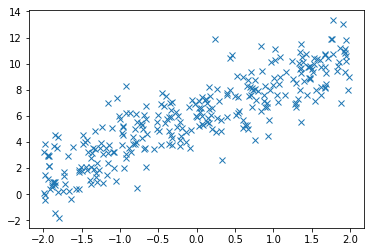

In [2]:
SLOPE = 2.25
INTERCEPT = 6
NOISE_STDDEV = 1.5

def gen(x):
    pos = SLOPE * x + INTERCEPT
    return np.random.normal(pos, NOISE_STDDEV)

data = np.array([[x, gen(x)] for x in np.random.uniform(-2, 2, 300)])
line, = plt.plot(data[:, 0], data[:, 1], 'x')

To fit the line, we first define a cost function. Mean Squared Error:

$$ \hat{y}(x) = mx + b $$
$$ MSE(m, b) = \frac{1}{n} \sum\limits_{i=1}^{n} (\hat{y}_i - y_i)^2 $$
$$ = \frac{1}{n} \sum\limits_{i=1}^{n} (mx_i + b - y_i)^2 $$
$$ = \frac{1}{n} \sum\limits_{i=1}^{n} (mx_i)^2 + 2mx_ib - 2m x_i y_i + b^2 - 2by_i + y_i^2 $$

In [3]:
def mse(x: np.ndarray, y: np.ndarray, m: int, b: int):
    """MSE computed against a whole set of inputs at once.
    
    Args:
        x: input xs, ndarray with dims [:, 1]
        y: input ys, ndarray with dims [:, 1]
        m: current slope
        b: current intercept
    """
    if isinstance(m, np.ndarray):
        y_hat = x.dot(m) + b
    else:
        y_hat = m * x + b
    diff = y_hat - y
    total = np.sum(np.square(diff))
    return total / len(x)

To perform gradient descent, we find where the cost function (MSE here) decreases the fastest, and step in that direction. Repeat as needed. To find this direction of fastest decrease we'll need the derivatives:

$$ \frac{\partial MSE}{\partial m} = \frac{1}{n} \sum\limits_{i=1}^{n} 2mx_i^2 + 2x_i b - 2x_i y_i $$
$$ = \frac{2}{n} \sum\limits_{i=1}^{n} mx_i^2 + x_i b - x_i y_i $$
$$ = \frac{2}{n} \sum\limits_{i=1}^{n} x_i(mx_i + b - y_i) $$
$$ = \frac{2}{n} \sum\limits_{i=1}^{n} x_i(\hat{y}_i - y_i) $$

$$ \frac{\partial MSE}{\partial b} = \frac{1}{n} \sum\limits_{i=1}^{n} 2mx_i + 2b - 2y_i $$
$$ = \frac{2}{n} \sum\limits_{i=1}^{n} mx_i + b - y_i $$
$$ = \frac{2}{n} \sum\limits_{i=1}^{n} \hat{y}_i - y_i $$

So for each descent, with hyperparameter $ \alpha $ as our learning rate:

$$ m = m - \alpha \frac{\partial MSE}{\partial m} $$
$$ b = b - \alpha \frac{\partial MSE}{\partial b} $$




In [4]:
def gradient_descent(x: np.ndarray, y: np.ndarray, learning_rate=0.1):
    """Run gradient descent to fit a line y^ = x * m + b
    
    Args:
        x: input xs, ndarray with dims [:, 1]
        y: input ys, ndarray with dims [:, 1]
        
    At each step, yields `(m, b, cost)` where m, b are the line parameters and cost is the MSE for this step.
    """
    m = 0
    b = 0
    n = len(x)
    while True:
        cost = mse(x, y, m, b)
        yield m, b, cost
        y_hat = m * x + b
        diff = y_hat - y
        m -= learning_rate * (2/n) * np.sum(x * diff)
        b -= learning_rate * (2/n) * np.sum(diff)

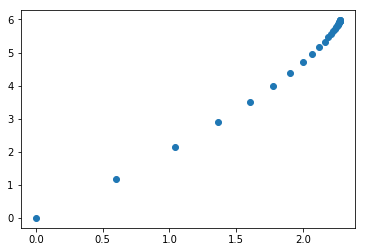

In [5]:
train_op = gradient_descent(data[:, 0], data[:, 1])
fit = np.array([next(train_op) for _ in range(30)])
line, = plt.plot(fit[:, 0], fit[:, 1], 'o')

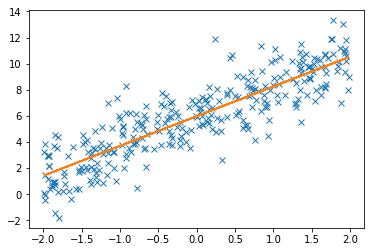

In [6]:
m, b, _ = fit[-1]
g, = plt.plot(data[:, 0], data[:, 1], 'x')
g, = plt.plot(data[:, 0], list(map(lambda x: m * x + b, data[:, 0])), '-')

# Multiple Linear Regression

Multivariate linear regression with multiple input variables. Single number $m$ becomes vector $\theta$ and $\hat{y}(x) = \theta^T \cdot x$ (dot product)

Solving for one row at a time:

$$ \theta \cdot x_i = \theta_1 x_{i,1} + \theta_2 x_{i,2} + ... + \theta_j x_{i,j} $$
$$ MSE = \frac{1}{n} \sum\limits_{i=1}^{n} (\hat{y}(x_i) - y_i)^2 $$
$$ \frac{\partial MSE}{\partial \theta_j} = \frac{1}{n} \sum\limits_{i=1}^{n} (\hat{y}(x_i) - y_i)^2 $$
$$ = \frac{1}{n} \sum\limits_{i=1}^{n} \frac{\partial MSE}{\partial \theta_j}  (\hat{y}(x_i) - y_i)^2 $$
Using the chain rule:
$$ = \frac{1}{n} \sum\limits_{i=1}^{n} 2(\hat{y}(x_i)-y_i) \frac{\partial MSE}{\partial \theta_j} (\hat{y}(x_i) - y_i)  $$
$$ = \frac{1}{n} \sum\limits_{i=1}^{n} 2(\hat{y}(x_i)-y_i) \frac{\partial MSE}{\partial \theta_j}(\theta^T \cdot x) - 0 $$
For a given derivative $ \frac{\partial MSE}{\partial \theta_j} $ all components of the dot product $\hat{y}(x)$ are $0$ except for at $\theta_j$:
$$ = \frac{2}{n} \sum\limits_{i=1}^{n} (\hat{y}(x_i)-y_i) x_{i,j} $$




In [7]:
def multiple_gradient_descent_1(x: np.ndarray, y: np.ndarray, lr = 0.1):
    """Run gradient descent to fit a multivariate equation y^ = x * m + b
    
    Args:
        x: input xs, ndarray with dims [:, f]
        y: input ys, ndarray with dims [:, 1]
        
    Where `f` is number of input features.
    At each step, yields `(theta, b, cost)` where theta is a vector (ndarray [f]) of current parameters, b is the bias param, and cost is the MSE for this step.
    Operates on each row of x individually.
    """
    theta = np.zeros(x.shape[1])
    b = 0
    n = len(x)
    while True:
        cost = mse(x, y, theta, b)
        yield theta, b, cost
        theta = np.copy(theta)
        for i in range(n):
            xi = x[i]
            yi = y[i]
            y_hat = theta.T.dot(xi) + b
            diff = y_hat - yi
            b -= lr * (2/n) * diff
            for j in range(len(theta)):
                theta[j] -= lr * (2/n) * diff * xi[j]

In [8]:
SLOPES = [2.5, 1.3, 6.4, 2.7]
INTERCEPT = 6
NOISE_STDDEV = 1.5

def gen2(x):
    pos = np.sum(SLOPES * x) + INTERCEPT
    return np.random.normal(pos, NOISE_STDDEV)

Xs = np.random.rand(2000, 4) * 4.0 - 2.0
ys = np.array([gen2(x) for x in Xs])

final parameters:  [array([ 2.48911076,  1.28467769,  6.34022744,  2.74224512])
 6.0268144773164023 2.2962710560258102]


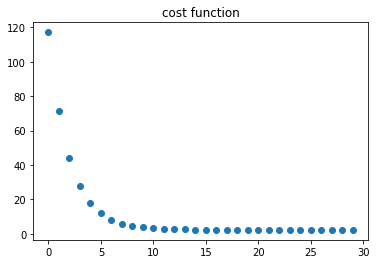

In [9]:
train_op = multiple_gradient_descent_1(Xs, ys)
fit = np.array([next(train_op) for _ in range(30)])
plt.plot(fit[:, 2], 'o')
plt.title('cost function')
print("final parameters: ", fit[-1])

In [10]:
# operate over all xs at once
def multiple_gradient_descent_2(x: np.ndarray, y: np.ndarray, lr = 0.1):
    """Run gradient descent to fit a multivariate equation y^ = x * m + b
    
    Args:
        x: input xs, ndarray with dims [:, f]
        y: input ys, ndarray with dims [:, 1]
        
    Where `f` is number of input features.
    At each step, yields `(theta, b, cost)` where theta is a vector (ndarray [f]) of current parameters, b is the bias param, and cost is the MSE for this step.
    """
    theta = np.zeros(x.shape[1])
    b = 0
    n = len(x)
    while True:
        cost = mse(x, y, theta, b)
        yield theta, b, cost
        theta = np.copy(theta)
        # compute the function for all inputs in one go
        y_hat = x.dot(theta) + b
        diff = y_hat - y
        b -= lr * (2/n) * np.sum(diff)
        for j in range(len(theta)):
            theta[j] -= lr * (2/n) * np.sum(diff * x[:, j])

final parameters:  [array([ 2.48700526,  1.28786562,  6.34037619,  2.74297647])
 6.0365675415311353 2.2959835940582649]


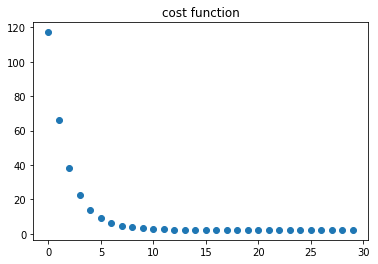

In [11]:
train_op = multiple_gradient_descent_2(Xs, ys)
fit = np.array([next(train_op) for _ in range(30)])
plt.plot(fit[:, 2], 'o')
plt.title('cost function')
print("final parameters: ", fit[-1])

In [21]:
# compute theta's update in one go
def multiple_gradient_descent_3(x: np.ndarray, y: np.ndarray, lr = 0.1):
    """Run gradient descent to fit a multivariate equation y^ = x * m + b
    
    Args:
        x: input xs, ndarray with dims [:, f]
        y: input ys, ndarray with dims [:, 1]
        
    Where `f` is number of input features.
    At each step, yields `(theta, b, cost)` where theta is a vector (ndarray [f]) of current parameters, b is the bias param, and cost is the MSE for this step.
    """
    theta = np.zeros(x.shape[1])
    b = 0
    n = len(x)
    while True:
        cost = mse(x, y, theta, b)
        yield theta, b, cost
        # compute the function for all inputs in one go
        y_hat = x.dot(theta) + b
        diff = y_hat - y
        b -= lr * (2/n) * np.sum(diff)
        # update theta all at once with a matrix op
        # theta.shape == (4, 1)
        # x.shape == (40, 4)
        # diff.shape == (40, 1)
        # x.T.shape == (4, 40)
        theta = theta - lr * (2/n) * x.T.dot(diff)

final parameters:  [array([ 2.48700526,  1.28786562,  6.34037619,  2.74297647])
 6.0365675415311353 2.2959835940582649]


array([[array([ 0.,  0.,  0.,  0.]), 0, 117.16338492535064],
       [array([ 0.72394609,  0.46971562,  1.7574616 ,  0.72586114]),
        1.2295320396993477, 66.112299494024512],
       [array([ 1.23736445,  0.77994499,  3.02781855,  1.25752225]),
        2.2073586888742831, 38.127110617489251],
       [array([ 1.60142762,  0.98254254,  3.94616801,  1.6474927 ]),
        2.9854614808225945, 22.635441849560635],
       [array([ 1.8595464 ,  1.11298017,  4.61009664,  1.93394329]),
        3.6049628045810058, 13.97036377651172],
       [array([ 2.04252365,  1.19541944,  5.09011007,  2.14465735]),
        4.0984281068111592, 9.0710352416867792],
       [array([ 2.17221347,  1.24623659,  5.4371581 ,  2.29988406]),
        4.4916709635717549, 6.2701875856754201],
       [array([ 2.26411915,  1.27646688,  5.6880656 ,  2.41440126]),
        4.8051707686294884, 4.6512290897022117],
       [array([ 2.32923733,  1.2934956 ,  5.86945298,  2.49900848]),
        5.0551879328535856, 3.705243402814403

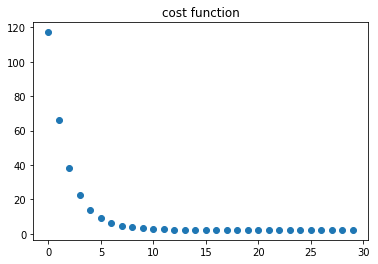

In [22]:
train_op = multiple_gradient_descent_3(Xs, ys)
fit = np.array([next(train_op) for _ in range(30)])
plt.plot(fit[:, 2], 'o')
plt.title('cost function')
print("final parameters: ", fit[-1])
fit